In [1]:
!pip install lime

In [2]:
import os
import requests
import numpy as np
import torch
from PIL import Image
from torchvision import models, transforms
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from sklearn.linear_model import Ridge
import time


In [3]:
# Step 1: Setup + Download Images

image_urls = {
    "West_Highland_white_terrier": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02098286_West_Highland_white_terrier.JPEG",
    "American_coot": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02018207_American_coot.JPEG",
    "racer": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n04037443_racer.JPEG",
    "flamingo": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02007558_flamingo.JPEG",
    "kite": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01608432_kite.JPEG",
    "goldfish": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01443537_goldfish.JPEG",
    "tiger_shark": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01491361_tiger_shark.JPEG",
    "vulture": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01616318_vulture.JPEG",
    "common_iguana": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01677366_common_iguana.JPEG",
    "orange": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07747607_orange.JPEG"
}

os.makedirs("images", exist_ok=True)

for name, url in image_urls.items():
    path = f"images/{name}.jpeg"
    if not os.path.exists(path):
        response = requests.get(url)
        with open(path, "wb") as f:
            f.write(response.content)
        print(f"Downloaded: {name}")
    else:
        print(f"Already exists: {name}")


✅ Downloaded: West_Highland_white_terrier
✅ Downloaded: American_coot
✅ Downloaded: racer
✅ Downloaded: flamingo
✅ Downloaded: kite
✅ Downloaded: goldfish
✅ Downloaded: tiger_shark
✅ Downloaded: vulture
✅ Downloaded: common_iguana
✅ Downloaded: orange


In [4]:
output_dir = "/kaggle/working/images"
output_vis_dir = "/kaggle/working/lime_outputs"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_vis_dir, exist_ok=True)
print(f"Using image directory: {output_dir}")
print(f"Using visualization directory: {output_vis_dir}")


Using image directory: /kaggle/working/images
Using visualization directory: /kaggle/working/lime_outputs


In [5]:
# Step 2: Load Model and Preprocessing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device).eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess(Image.fromarray(img)).to(device) for img in images), dim=0)
    with torch.no_grad():
        logits = model(batch)
    return torch.softmax(logits, dim=1).cpu().numpy()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 91.9MB/s]


Processing Images:   0%|          | 0/10 [00:00<?, ?it/s]

West_Highland_white_terrier → Top label: 203 (prob: 0.5610)


  0%|          | 0/600 [00:00<?, ?it/s]

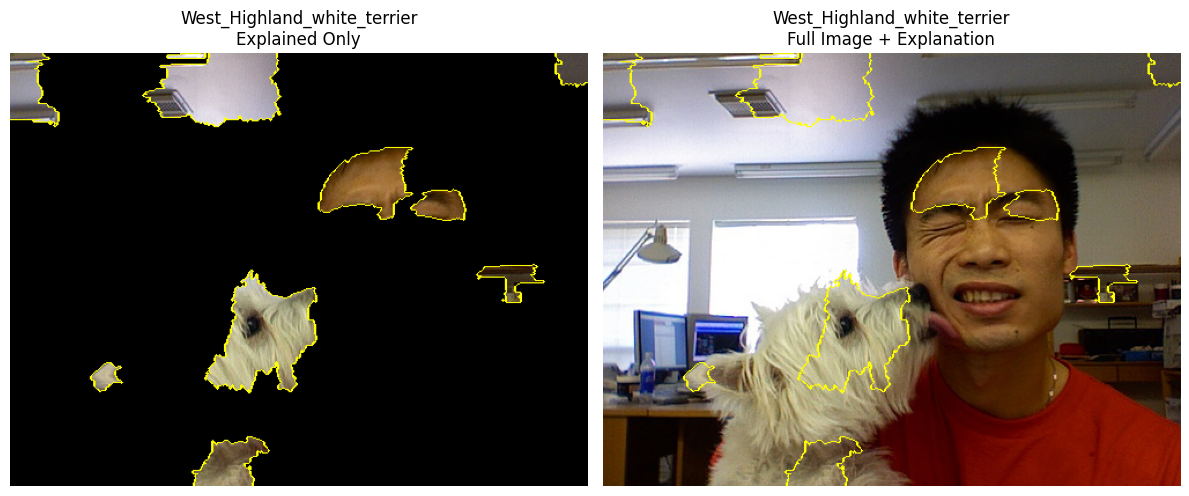

Processing Images:  10%|█         | 1/10 [00:15<02:18, 15.44s/it]

Processed West_Highland_white_terrier in 15.44 seconds
American_coot → Top label: 137 (prob: 0.6030)


  0%|          | 0/600 [00:00<?, ?it/s]

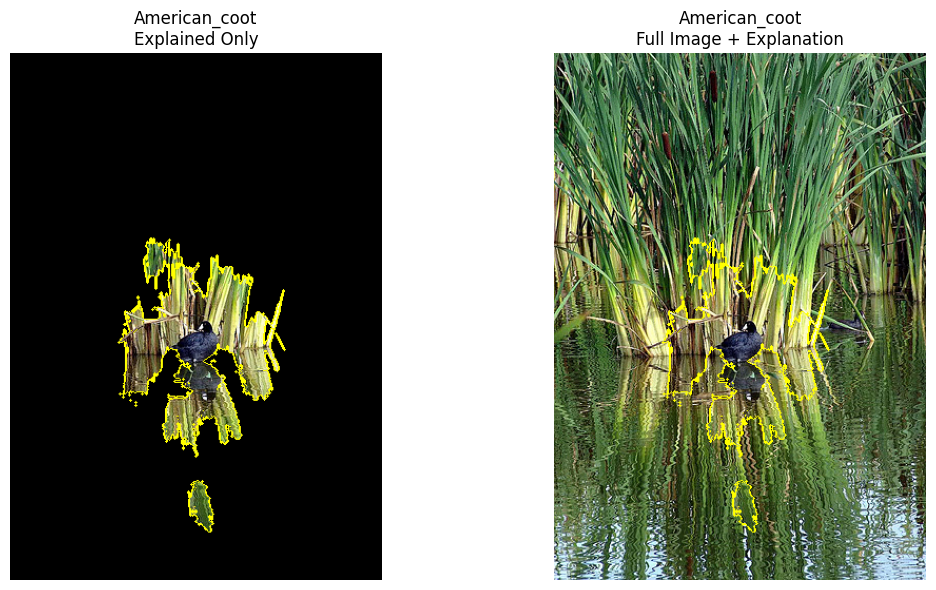

Processing Images:  20%|██        | 2/10 [00:30<02:03, 15.46s/it]

Processed American_coot in 15.47 seconds
racer → Top label: 817 (prob: 0.1884)


  0%|          | 0/600 [00:00<?, ?it/s]

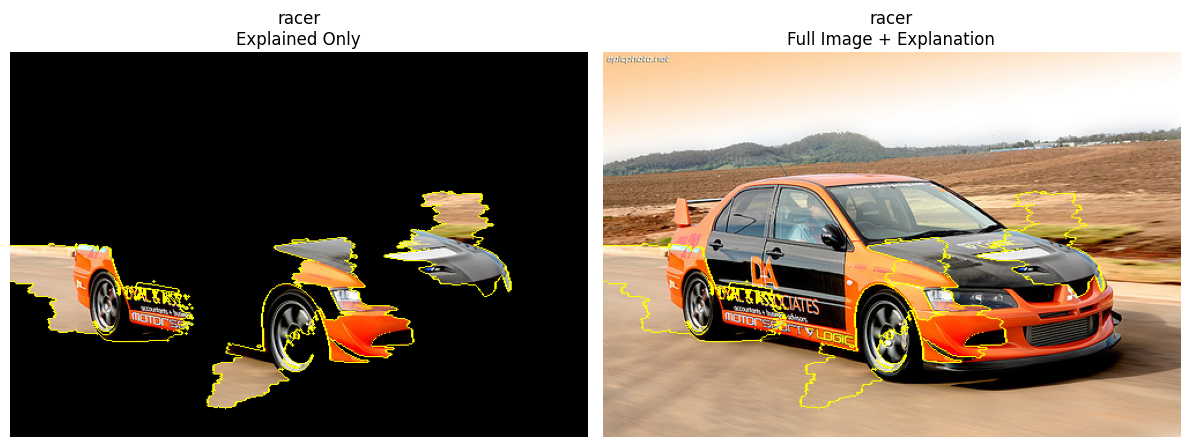

Processing Images:  30%|███       | 3/10 [00:43<01:39, 14.22s/it]

Processed racer in 12.75 seconds
flamingo → Top label: 130 (prob: 0.5369)


  0%|          | 0/600 [00:00<?, ?it/s]

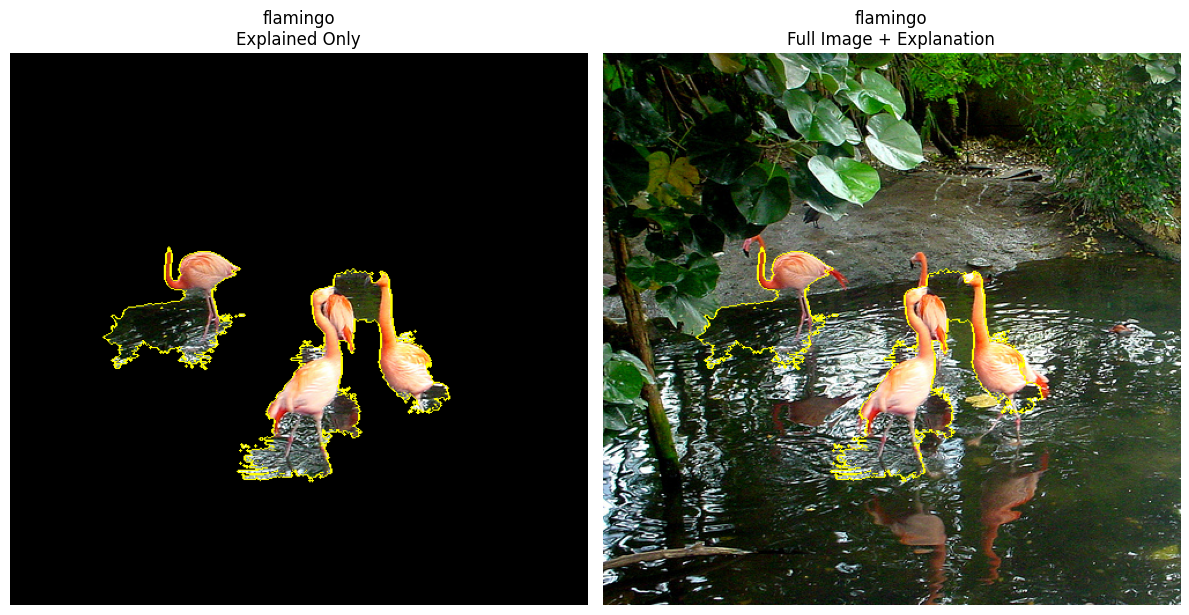

Processing Images:  40%|████      | 4/10 [01:04<01:40, 16.67s/it]

Processed flamingo in 20.42 seconds
kite → Top label: 129 (prob: 0.1173)


  0%|          | 0/600 [00:00<?, ?it/s]

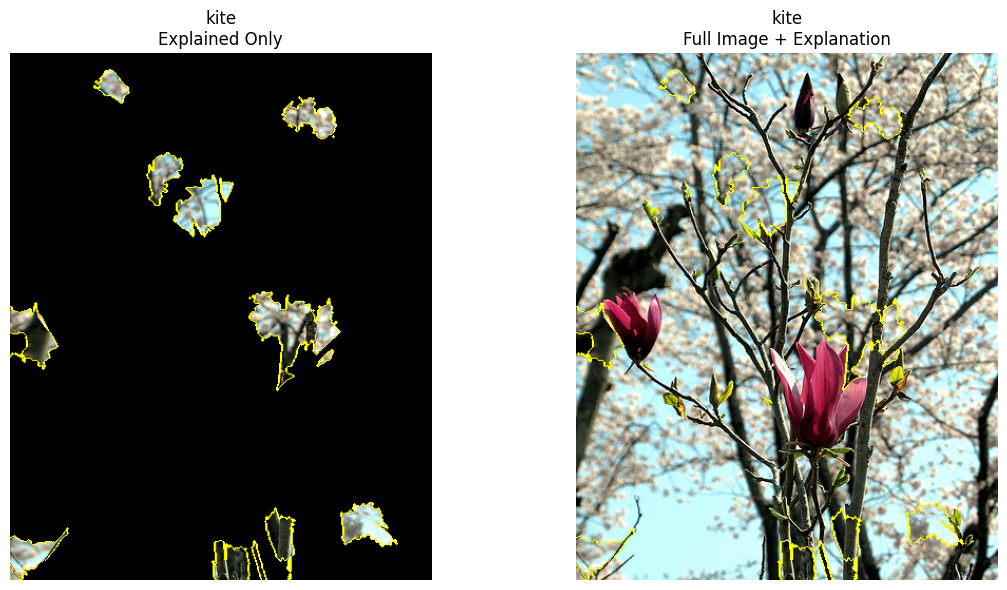

Processing Images:  50%|█████     | 5/10 [01:21<01:24, 16.87s/it]

Processed kite in 17.22 seconds
goldfish → Top label: 1 (prob: 0.5120)


  0%|          | 0/600 [00:00<?, ?it/s]

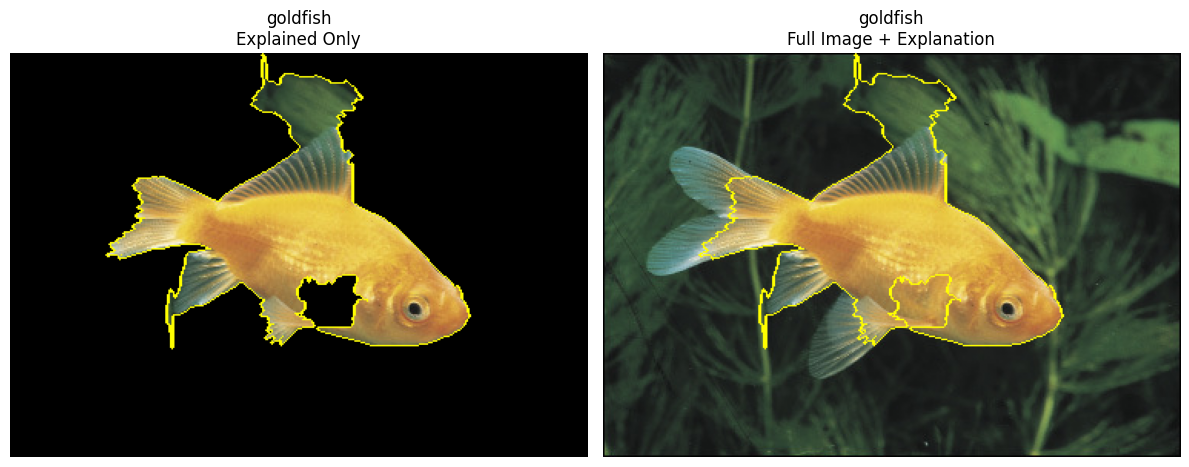

Processing Images:  60%|██████    | 6/10 [01:29<00:56, 14.01s/it]

Processed goldfish in 8.46 seconds
tiger_shark → Top label: 3 (prob: 0.5720)


  0%|          | 0/600 [00:00<?, ?it/s]

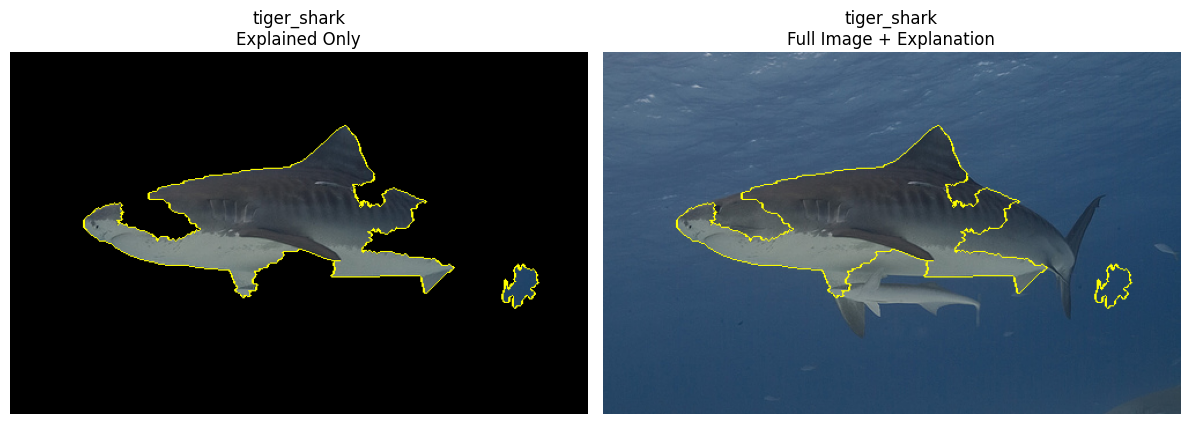

Processing Images:  70%|███████   | 7/10 [01:42<00:41, 13.73s/it]

Processed tiger_shark in 13.14 seconds
vulture → Top label: 23 (prob: 0.4001)


  0%|          | 0/600 [00:00<?, ?it/s]

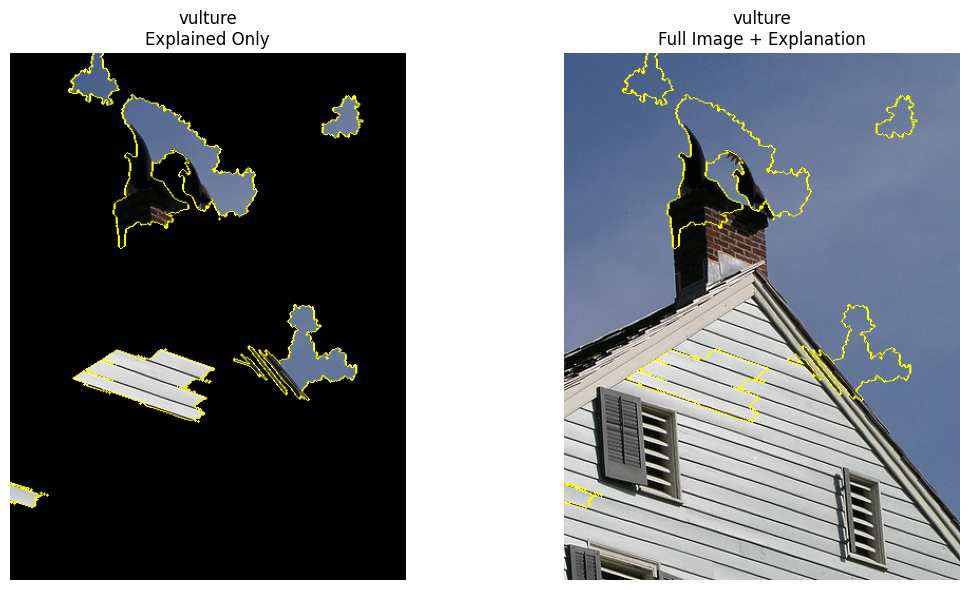

Processing Images:  80%|████████  | 8/10 [01:58<00:28, 14.19s/it]

Processed vulture in 15.17 seconds
common_iguana → Top label: 39 (prob: 0.3591)


  0%|          | 0/600 [00:00<?, ?it/s]

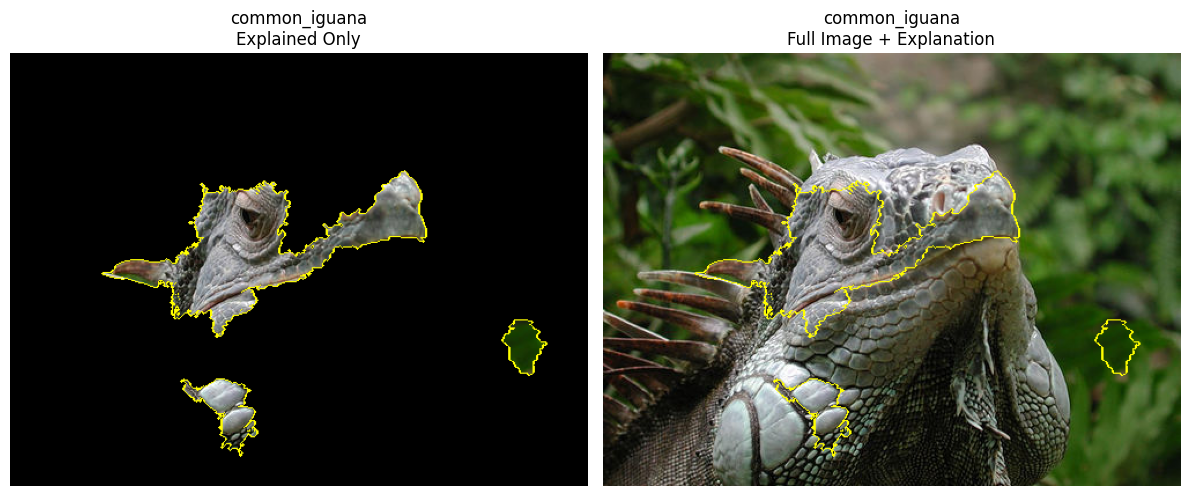

Processing Images:  90%|█████████ | 9/10 [02:13<00:14, 14.58s/it]

Processed common_iguana in 15.43 seconds
orange → Top label: 950 (prob: 0.3830)


  0%|          | 0/600 [00:00<?, ?it/s]

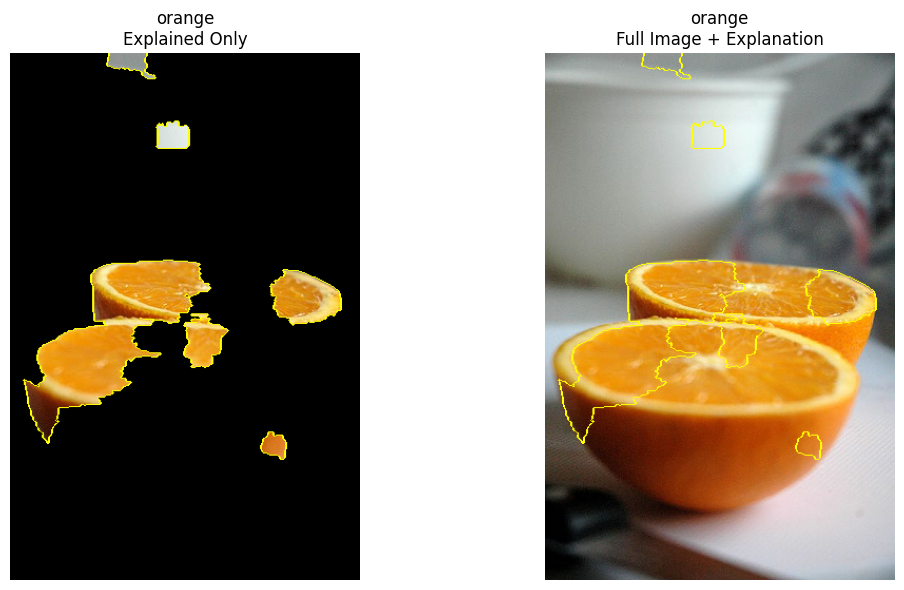

Processing Images: 100%|██████████| 10/10 [02:26<00:00, 14.65s/it]

Processed orange in 12.95 seconds


In [6]:
# Step 3: Run LIME Explanations and Visualize
lime_params_dict = {}

for name in tqdm(image_urls.keys(), desc="Processing Images"):
    image_path = os.path.join(output_dir, f"{name}.jpeg")
    
    if not os.path.exists(image_path):
        print(f"Downloading {name}...")
        try:
            img_data = requests.get(image_urls[name]).content
            with open(image_path, "wb") as f:
                f.write(img_data)
        except Exception as e:
            print(f"Failed to download {name}: {e}")
            continue

    start_time = time.time()
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)

    # Get top predicted label
    img_tensor = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(img_tensor)
        probs = torch.softmax(logits, dim=1)
        top_label = torch.argmax(probs, dim=1).item()
        print(f"{name} → Top label: {top_label} (prob: {probs[0, top_label]:.4f})")

    explainer = lime_image.LimeImageExplainer(random_state=42)

    params = {
        'labels': (top_label,),
        'hide_color': [0, 0, 0],
        'top_labels': 1,
        'num_features': 12,
        'num_samples': 600,
        'batch_size': 10,
        'segmentation_fn': SegmentationAlgorithm(
            'quickshift',
            kernel_size=4,
            max_dist=150,
            ratio=0.3
        ),
        'distance_metric': 'cosine',
        'model_regressor': Ridge(alpha=0.5),
        'random_seed': 42
    }

    try:
        explanation = explainer.explain_instance(
            image=img_np,
            classifier_fn=batch_predict,
            **params
        )

        # Two-panel visualization
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Left: only explanation, black background
        temp1, mask1 = explanation.get_image_and_mask(
            label=explanation.top_labels[0],
            positive_only=True,
            num_features=params['num_features'],
            hide_rest=True
        )
        axes[0].imshow(mark_boundaries(temp1 / 255.0, mask1))
        axes[0].set_title(f"{name}\nExplained Only")
        axes[0].axis('off')

        # Right: full image with explanation overlay
        temp2, mask2 = explanation.get_image_and_mask(
            label=explanation.top_labels[0],
            positive_only=True,
            num_features=params['num_features'],
            hide_rest=False
        )
        axes[1].imshow(mark_boundaries(temp2 / 255.0, mask2))
        axes[1].set_title(f"{name}\nFull Image + Explanation")
        axes[1].axis('off')

        # Save and close
        plt.tight_layout()
        save_path = os.path.join(output_vis_dir, f"{name}_lime_grid.png")
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.show()
        plt.close()

        exec_time = time.time() - start_time
        print(f"Processed {name} in {exec_time:.2f} seconds")

        lime_params_dict[name] = {k: v for k, v in params.items() if k not in ['image', 'classifier_fn']}

    except Exception as e:
        print(f"Error processing {name}: {e}")
        continue



In [7]:
# Step 4: Save LIME Parameters
output_param_path = "/kaggle/working/final_lime_params.pkl"
if lime_params_dict:
    with open(output_param_path, "wb") as f:
        pickle.dump(lime_params_dict, f)
    print(f"LIME parameters saved to: {output_param_path}")
else:
    print("No parameters saved due to errors.")

LIME parameters saved to: /kaggle/working/final_lime_params.pkl


In [8]:
response = requests.post("http://34.122.51.94:9091/lime", files={"file": open("/kaggle/working/final_lime_params.pkl", "rb")}, headers={"token": "12910150"})
print(response.json())

{'avg_iou': 0.33054653157713176, 'avg_time': 2.8014615774154663}
